In [1]:
from google.colab import drive
drive.mount("/gdrive", force_remount=True)

Mounted at /gdrive


In [2]:
import pandas as pd
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.formula.api import ols
from statsmodels.api import qqplot, add_constant
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.model_selection import train_test_split
from statsmodels.api import Logit
from sklearn.linear_model import LinearRegression

from sklearn.metrics import r2_score

from sklearn.linear_model import Ridge, Lasso, ElasticNet

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.tree import export_graphviz
import graphviz

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
#1. 데이터 구성하기(1)
df_raw = pd.read_csv("/gdrive/MyDrive/POSCO_data_project/data/AIR_POLLUTION.csv")
df_raw.head()

,MeasDate,PM10,O3,NO2,CO,SO2,TEMP,RAIN,WIND,WIND_DIR,HUMIDITY,ATM_PRESS,SNOW,CLOUD
0,2019-07-01,29.0,0.054,0.021,0.5,0.003,24.03,0.0,2.30,249,63.2,995.1,0.0,5.70
1,2019-07-02,26.0,0.053,0.020,0.5,0.003,24.29,0.0,2.26,265,63.2,998.6,0.0,3.83
2,2019-07-03,30.0,0.042,0.023,0.4,0.003,24.18,0.0,1.79,280,65.3,998.3,0.0,6.29
3,2019-07-04,28.0,0.034,0.026,0.4,0.003,25.35,0.0,2.04,263,58.6,996.6,0.0,2.54
4,2019-07-05,29.0,0.045,0.035,0.5,0.003,27.30,0.0,1.45,175,45.5,993.5,0.0,3.92


In [4]:
#1. 데이터 구성하기(2)
#교재에서 변수 MeasDate의 변수 역할에 '제외'라고 되어있으니 drop한다.

df_raw.drop(["MeasDate"], axis=1, inplace=True)
df_raw.head()

,PM10,O3,NO2,CO,SO2,TEMP,RAIN,WIND,WIND_DIR,HUMIDITY,ATM_PRESS,SNOW,CLOUD
0,29.0,0.054,0.021,0.5,0.003,24.03,0.0,2.30,249,63.2,995.1,0.0,5.70
1,26.0,0.053,0.020,0.5,0.003,24.29,0.0,2.26,265,63.2,998.6,0.0,3.83
2,30.0,0.042,0.023,0.4,0.003,24.18,0.0,1.79,280,65.3,998.3,0.0,6.29
3,28.0,0.034,0.026,0.4,0.003,25.35,0.0,2.04,263,58.6,996.6,0.0,2.54
4,29.0,0.045,0.035,0.5,0.003,27.30,0.0,1.45,175,45.5,993.5,0.0,3.92


In [5]:
#1. 데이터 구성하기(3) - 결측치 확인
df_raw.isnull().sum()

PM10          1
O3            1
NO2           1
CO           55
SO2           1
TEMP          0
RAIN          0
WIND          0
WIND_DIR      0
HUMIDITY      0
ATM_PRESS     0
SNOW          0
CLOUD         0
dtype: int64

In [6]:
#1. 데이터 구성하기(4) - 결측치 확인
#1-1) PM10, O3, NO2, CO, SO2의 결측치가 동일 행에 위치해 있다.
df_raw[df_raw['PM10'].isnull()]

,PM10,O3,NO2,CO,SO2,TEMP,RAIN,WIND,WIND_DIR,HUMIDITY,ATM_PRESS,SNOW,CLOUD
328,NaN,NaN,NaN,NaN,NaN,17.48,1.45,2.85,257,83.3,999.4,0.0,8.21


In [7]:
#1. 데이터 구성하기(5) - 결측치 제거
#1-2) 행 제거
df_raw.drop(index=328, axis=0, inplace=True)
df_raw.isnull().sum()

PM10          0
O3            0
NO2           0
CO           54
SO2           0
TEMP          0
RAIN          0
WIND          0
WIND_DIR      0
HUMIDITY      0
ATM_PRESS     0
SNOW          0
CLOUD         0
dtype: int64

In [8]:
#1. 데이터 구성하기(6) - 결측치 확인
#2-1) CO의 결측치 위치를 확인한다.
index_list = df_raw[df_raw['CO'].isnull()].index
len(index_list)

54

In [9]:
#1. 데이터 구성하기(7) - 결측치 제거
#2-2) CO의 결측치 위치 행 전부 삭제
df_raw.drop(index_list, inplace=True)

In [10]:
#1. 데이터 구성하기(8)
#3) 결측치 처리 결과 확인
df_raw.isnull().sum()

PM10         0
O3           0
NO2          0
CO           0
SO2          0
TEMP         0
RAIN         0
WIND         0
WIND_DIR     0
HUMIDITY     0
ATM_PRESS    0
SNOW         0
CLOUD        0
dtype: int64

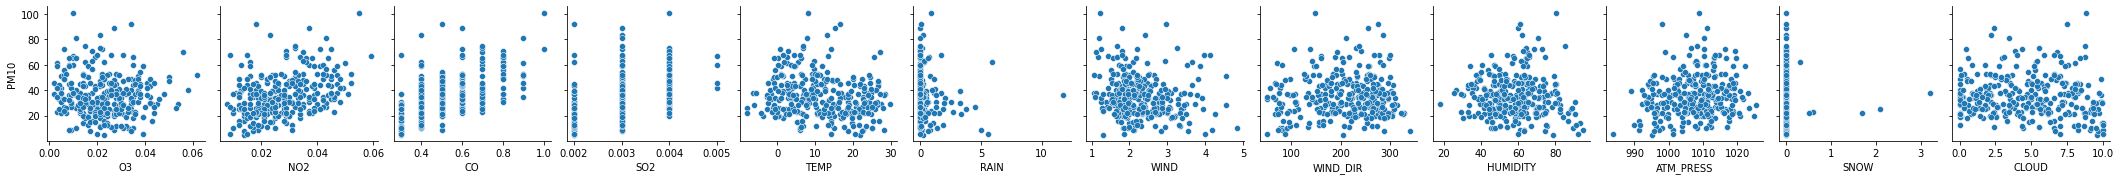

In [11]:
#2. 목표변수와 설명변수 관계 확인
sns.pairplot(df_raw, y_vars="PM10", x_vars=["O3", "NO2", "CO", "SO2", "TEMP",\
                                             "RAIN", "WIND", "WIND_DIR", "HUMIDITY",\
                                             "ATM_PRESS", "SNOW", "CLOUD"])

1. NO2의 경우, PM10와 비례관계가 있는 것처럼 보인다.
반면에, WIND의 경우, PM10과 반비례관계가 있는 것처럼 산점도에서 보인다.
  
**가설1. NO2의 값이 높을 수록 미세먼지 양이 많아진다.**
- NO2(이산화질소)는 대기 중 기체가 아닌 미세먼지로 바뀌기도 한다.
 
  
**가설2. 풍속이 높을 수록 미세먼지 양은 낮아진다.**
- 논문을 보면, 미세먼지가 낮아지는 데 영향을 준다고 한다.

2. RAIN과 SNOW를 보면, PM10과 서로 연관성이 크게 없는 것을 알 수 있다.
RAIN과 SNOW의 값이 0에 가까울 때, PM10의 값이 적은 것부터 높은 것까지 다양하게 분포되어있기 때문이다.
**따라서 RAIN과 SNOW는 설명변수에서 제외하도록 한다.**

3. CO와 SO2의 경우, 값이 범주화되어 있기에 Bar Chart와 Box Plot을 통해 다시 확인해본다.

4. 많은 논문에서 WIND_DIR(풍향)은 미세먼지에 영향을 주는 요인으로 많이 뽑기 때문에 주요인자일 것으로 보인다.
- 해당 데이터셋의 데이터 개수가 적기 때문에 16방위가 아닌 4방위로 나눠서 Bar Chart와 Box Plot을 통해 다시 확인해본다.

5. CLOUD는 0.0~10.0까지 분포되어 있는데, 이를 범주화해서 다시 확인해본다.

AxesSubplot(0.125,0.125;0.775x0.755)
AxesSubplot(0.1,0.15;0.8x0.75)


/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


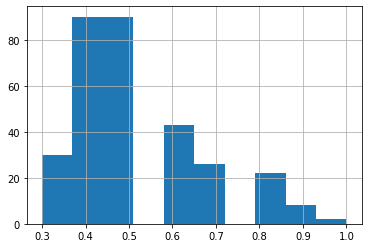

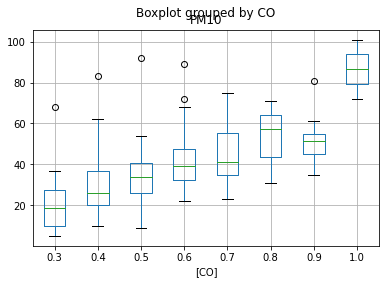

In [12]:
#2. 목표변수와 설명변수 관계 확인
#1) CO
print(df_raw["CO"].hist())
print(df_raw.boxplot(column="PM10", by=["CO"]))

## Box Plot을 통해 CO값이 클 수록 미세먼지 양도 많아진다는 것을 확인할 수 있다.
- 앞서 데이터 결측치로 인해 많은 데이터 수를 줄였다. 따라서 이상치는 제거하지 않는다. 

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


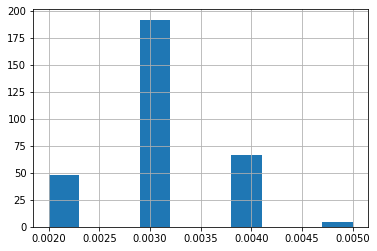

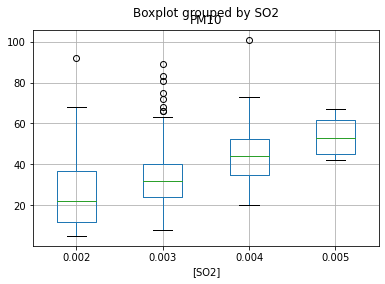

In [13]:
#2) SO2
df_raw["SO2"].hist()
df_raw.boxplot(column="PM10", by=["SO2"])

## Box Plot을 통해 SO2값이 클 수록 미세먼지 양도 많아진다는 것을 확인할 수 있다.
- 앞서 데이터 결측치로 인해 많은 데이터 수를 줄였다. 따라서 이상치는 제거하지 않는다. 

In [14]:
#3) WIND - 범주화(1): 최소값과 최대값 확인
print(df_raw['WIND'].min())
print(df_raw['WIND'].max())

1.05
4.83


In [15]:
#3) WIND - 범주화(2): 5개로 범주화
df_raw.loc[(df_raw['WIND']>1) & (df_raw['WIND']<1.5), 'WIND_Cat'] = 'W1'
df_raw.loc[(df_raw['WIND']>=1.5) & (df_raw['WIND']<2.5), 'WIND_Cat'] = 'W2'
df_raw.loc[(df_raw['WIND']>=2.5) & (df_raw['WIND']<3.5), 'WIND_Cat'] = 'W3'
df_raw.loc[(df_raw['WIND']>=3.5) & (df_raw['WIND']<4.5), 'WIND_Cat'] = 'W4'
df_raw.loc[(df_raw['WIND']>=4.5) & (df_raw['WIND']<5.5), 'WIND_Cat'] = 'W5'

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


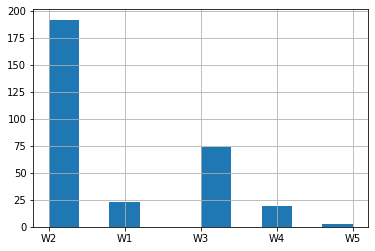

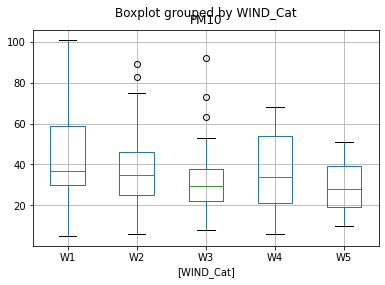

In [16]:
df_raw['WIND_Cat'].hist()
df_raw.boxplot(column="PM10", by=["WIND_Cat"])

## Box Plot을 통해 풍속이 강할 수록 미세먼지의 양이 줄어드는 것을 볼 수 있다. 단, Histogram을 통해 풍속의 단계별로 미세먼지의 발생 횟수가 일정하지는 않아 확신할 수는 없다. 
- 앞서 데이터 결측치로 인해 많은 데이터 수를 줄였다. 따라서 이상치는 제거하지 않는다. 

In [17]:
#4) WIND_DIR - 범주화: 풍향을 4방위로 나누기
df_raw.loc[(df_raw['WIND_DIR']>45) & (df_raw['WIND_DIR']<=135), 'WIND_DIR_Cat'] = 'E'
df_raw.loc[(df_raw['WIND_DIR']>225) & (df_raw['WIND_DIR']<=315), 'WIND_DIR_Cat'] = 'W'
df_raw.loc[(df_raw['WIND_DIR']>135) & (df_raw['WIND_DIR']<=225), 'WIND_DIR_Cat'] = 'S'
df_raw.loc[(df_raw['WIND_DIR']>315) & (df_raw['WIND_DIR']<=360), 'WIND_DIR_Cat'] = 'N'

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


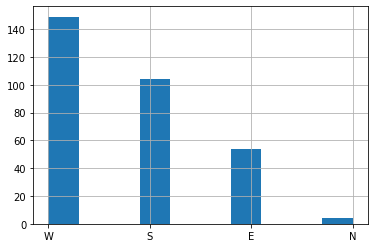

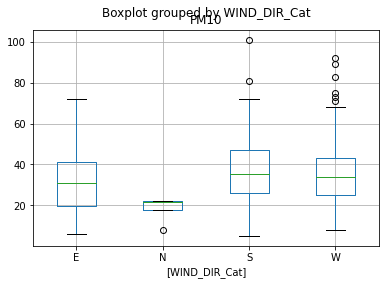

In [18]:
df_raw['WIND_DIR_Cat'].hist()
df_raw.boxplot(column="PM10", by=["WIND_DIR_Cat"])

## 서풍>남풍>동풍>북풍 순으로 미세먼지 발생 횟수가 많아지며 미세먼지 양도 다양하게 분포되어 있다는 것을 볼 수 있다.
- 앞서 데이터 결측치로 인해 많은 데이터 수를 줄였다. 따라서 이상치는 제거하지 않는다. 

In [19]:
#5) CLOUD - 범주화(1): 최소값과 최대값 확인
print(df_raw['CLOUD'].min())
print(df_raw['CLOUD'].max())

0.0
10.0


In [20]:
#5) CLOUD - 범주화(2): 10개로 범주화
df_raw.loc[(df_raw['CLOUD']>=0) & (df_raw['CLOUD']<0.5), 'CLOUD_Cat'] = 'C0'
df_raw.loc[(df_raw['CLOUD']>=0.5) & (df_raw['CLOUD']<1.5), 'CLOUD_Cat'] = 'C1'
df_raw.loc[(df_raw['CLOUD']>=1.5) & (df_raw['CLOUD']<2.5), 'CLOUD_Cat'] = 'C2'
df_raw.loc[(df_raw['CLOUD']>=2.5) & (df_raw['CLOUD']<3.5), 'CLOUD_Cat'] = 'C3'
df_raw.loc[(df_raw['CLOUD']>=3.5) & (df_raw['CLOUD']<4.5), 'CLOUD_Cat'] = 'C4'
df_raw.loc[(df_raw['CLOUD']>=4.5) & (df_raw['CLOUD']<5.5), 'CLOUD_Cat'] = 'C5'
df_raw.loc[(df_raw['CLOUD']>=5.5) & (df_raw['CLOUD']<6.5), 'CLOUD_Cat'] = 'C6'
df_raw.loc[(df_raw['CLOUD']>=6.5) & (df_raw['CLOUD']<7.5), 'CLOUD_Cat'] = 'C7'
df_raw.loc[(df_raw['CLOUD']>=7.5) & (df_raw['CLOUD']<8.5), 'CLOUD_Cat'] = 'C8'
df_raw.loc[(df_raw['CLOUD']>=8.5) & (df_raw['CLOUD']<9.5), 'CLOUD_Cat'] = 'C9'
df_raw.loc[(df_raw['CLOUD']>=9.5) & (df_raw['CLOUD']<10.5), 'CLOUD_Cat'] = 'C10'

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


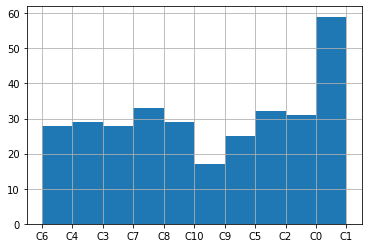

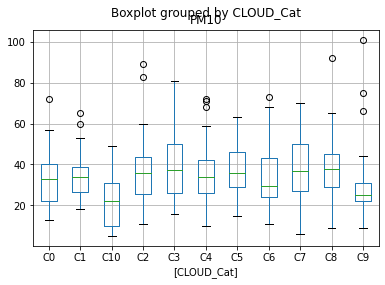

In [21]:
df_raw["CLOUD_Cat"].hist()
df_raw.boxplot(column="PM10", by=["CLOUD_Cat"])

## 전운량별로 발생 횟수가 거의 비슷하게 분포되어 있음에도 Box Plot을 통해 전운량은 미세 먼지에 발생에 큰 영향을 주지 않는다는 것을 파악할 수 있다.
- 앞서 데이터 결측치로 인해 많은 데이터 수를 줄였다. 따라서 이상치는 제거하지 않는다. 

In [22]:
#3. 필요없는 칼럼 제거
#1) RAIN과 SNOW 삭제.
df_raw.drop(["RAIN", "SNOW"], axis=1, inplace=True) 

In [23]:
#2) 위에서 생성한 CLOUD_Cat 삭제
df_raw.drop(["CLOUD_Cat"], axis=1, inplace=True) 

In [24]:
#3) WIND와 WIND_DIR 삭제 - WIND_Cat과 WIND_DIR_Cat으로 범주화했기 때문
df_raw.drop(["WIND", "WIND_DIR"], axis=1, inplace=True) 

In [25]:
df_raw.head()

,PM10,O3,NO2,CO,SO2,TEMP,HUMIDITY,ATM_PRESS,CLOUD,WIND_Cat,WIND_DIR_Cat
0,29.0,0.054,0.021,0.5,0.003,24.03,63.2,995.1,5.70,W2,W
1,26.0,0.053,0.020,0.5,0.003,24.29,63.2,998.6,3.83,W2,W
2,30.0,0.042,0.023,0.4,0.003,24.18,65.3,998.3,6.29,W2,W
3,28.0,0.034,0.026,0.4,0.003,25.35,58.6,996.6,2.54,W2,W
4,29.0,0.045,0.035,0.5,0.003,27.30,45.5,993.5,3.92,W1,S


In [26]:
#4. 더미 변수 생성
df_raw_dummy = pd.get_dummies(df_raw)

In [27]:
df_raw_dummy

,PM10,O3,NO2,CO,SO2,TEMP,HUMIDITY,ATM_PRESS,CLOUD,WIND_Cat_W1,WIND_Cat_W2,WIND_Cat_W3,WIND_Cat_W4,WIND_Cat_W5,WIND_DIR_Cat_E,WIND_DIR_Cat_N,WIND_DIR_Cat_S,WIND_DIR_Cat_W
0,29.0,0.054,0.021,0.5,0.003,24.03,63.2,995.1,5.70,0,1,0,0,0,0,0,0,1
1,26.0,0.053,0.020,0.5,0.003,24.29,63.2,998.6,3.83,0,1,0,0,0,0,0,0,1
2,30.0,0.042,0.023,0.4,0.003,24.18,65.3,998.3,6.29,0,1,0,0,0,0,0,0,1
3,28.0,0.034,0.026,0.4,0.003,25.35,58.6,996.6,2.54,0,1,0,0,0,0,0,0,1
4,29.0,0.045,0.035,0.5,0.003,27.30,45.5,993.5,3.92,1,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
361,19.0,0.039,0.016,0.4,0.003,21.66,84.0,996.0,8.73,0,0,1,0,0,0,0,0,1
362,22.0,0.044,0.017,0.4,0.004,23.94,69.8,995.8,6.21,0,1,0,0,0,0,0,1,0
363,27.0,0.044,0.009,0.4,0.003,25.03,71.3,994.7,2.63,0,1,0,0,0,0,0,0,1
364,36.0,0.026,0.028,0.6,0.003,24.06,75.5,992.9,7.58,0,1,0,0,0,1,0,0,0


# 1. 다중 선형 회귀분석

In [ ]:
#1. 변수 간의 경향성 파악: 상관관계 분석
df_raw_dummy.corr().round(3)

,PM10,O3,NO2,CO,SO2,TEMP,HUMIDITY,ATM_PRESS,CLOUD,WIND_Cat_W1,WIND_Cat_W2,WIND_Cat_W3,WIND_Cat_W4,WIND_Cat_W5,WIND_DIR_Cat_E,WIND_DIR_Cat_N,WIND_DIR_Cat_S,WIND_DIR_Cat_W
PM10,1.000,-0.065,0.384,0.588,0.390,-0.197,-0.048,0.165,-0.096,0.156,0.044,-0.141,0.004,-0.036,-0.139,-0.122,0.108,0.031
O3,-0.065,1.000,-0.642,-0.559,-0.297,0.593,-0.015,-0.612,-0.093,-0.119,-0.110,0.105,0.135,0.081,-0.273,0.007,-0.087,0.288
NO2,0.384,-0.642,1.000,0.811,0.576,-0.205,-0.034,0.409,0.045,0.307,0.307,-0.356,-0.272,-0.135,0.248,-0.110,0.257,-0.406
CO,0.588,-0.559,0.811,1.000,0.594,-0.400,0.063,0.429,0.040,0.266,0.192,-0.246,-0.196,-0.119,0.210,-0.125,0.153,-0.276
SO2,0.390,-0.297,0.576,0.594,1.000,-0.214,-0.237,0.317,-0.136,0.076,0.230,-0.158,-0.222,-0.116,-0.022,-0.104,0.137,-0.089
TEMP,-0.197,0.593,-0.205,-0.400,-0.214,1.000,0.323,-0.772,0.283,0.065,0.106,-0.108,-0.076,-0.044,-0.051,0.012,0.063,-0.024
HUMIDITY,-0.048,-0.015,-0.034,0.063,-0.237,0.323,1.000,-0.468,0.597,0.148,-0.082,-0.010,0.049,-0.069,0.051,0.008,0.048,-0.085
ATM_PRESS,0.165,-0.612,0.409,0.429,0.317,-0.772,-0.468,1.000,-0.397,0.011,0.073,-0.019,-0.107,-0.049,0.022,0.023,-0.042,0.018
CLOUD,-0.096,-0.093,0.045,0.040,-0.136,0.283,0.597,-0.397,1.000,0.097,-0.070,-0.010,0.039,0.033,0.264,0.011,0.093,-0.291
WIND_Cat_W1,0.156,-0.119,0.307,0.266,0.076,0.065,0.148,0.011,0.097,1.000,-0.359,-0.158,-0.072,-0.028,0.065,-0.032,0.164,-0.197


## 상관계수를 절대값을 취했을 때, 0.5를 기준으로 다중공선성을 확인해보자.
### - O3는 NO2, CO, TEMP, ATM_PRESS와 선형관계가 확인되었다.
### - NO2는 O3, CO, SO2와 선형관계가 확인되었다.
### - CO는 O3, NO2, SO2와 선형관계가 확인되었다.
### - SO2는 NO2, CO와 선형관계가 확인되었다.

### NO2, CO, SO2와 O3, NO2, CO가 서로 관계가 있다는 점을 알 수 있었는데
### 논문에 따르면, "각종 연소과정에서 발생하는 NO2는 O3와 반응해 질산을 생성하며 이는 암모니아와 반응해 질산암모늄이 되는데, 이는 곧 2차적 미세먼지라고 할 수 있다."고 한다.
### "SO2는 수증기와 반응해 황산이 되고 이는 암모니아와 반응해 황산암모늄이 되는데, 이는 곧 미세먼지 입자를 생성하도록 한다."고 한다.
### **즉, NO2, CO, SO2, O3 모두 미세먼지 발생 요인이라고 볼 수 있다고 생각할 수 있다.**

In [29]:
#2. train/test 데이터 분리
df_train_dummy, df_test_dummy = train_test_split(df_raw_dummy, test_size=0.3, random_state=1234)
print("train data size: {}".format(df_train_dummy.shape))
print("test data size: {}".format(df_test_dummy.shape))

train data size: (217, 18)
test data size: (94, 18)


In [ ]:
df_raw_dummy.columns

Index(['PM10', 'O3', 'NO2', 'CO', 'SO2', 'TEMP', 'HUMIDITY', 'ATM_PRESS',
       'CLOUD', 'WIND_Cat_W1', 'WIND_Cat_W2', 'WIND_Cat_W3', 'WIND_Cat_W4',
       'WIND_Cat_W5', 'WIND_DIR_Cat_E', 'WIND_DIR_Cat_N', 'WIND_DIR_Cat_S',
       'WIND_DIR_Cat_W'],
      dtype='object')

In [ ]:
#3. 회귀 모델 생성: 설명변수 전체(1)
reg_model = smf.ols(formula="PM10 ~ O3 + NO2 + CO + SO2 + TEMP + HUMIDITY + ATM_PRESS + CLOUD\
                                + WIND_DIR_Cat_E + WIND_DIR_Cat_N + WIND_DIR_Cat_S + WIND_DIR_Cat_W \
                                + WIND_Cat_W1 + WIND_Cat_W2 + WIND_Cat_W3 + WIND_Cat_W4 + WIND_Cat_W5", data=df_train_dummy)
reg_result = reg_model.fit()
print(reg_result.summary())

                            OLS Regression Results                            
Dep. Variable:                   PM10   R-squared:                       0.573
Model:                            OLS   Adj. R-squared:                  0.541
Method:                 Least Squares   F-statistic:                     17.97
Date:                Mon, 15 Aug 2022   Prob (F-statistic):           1.47e-29
Time:                        07:58:19   Log-Likelihood:                -795.92
No. Observations:                 217   AIC:                             1624.
Df Residuals:                     201   BIC:                             1678.
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         66.8374    128.948      0.

In [ ]:
#3. 회귀 모델 생성: 설명변수 간 다중공선성 확인(2)
df_train_x = df_train_dummy.drop("PM10", axis=1)

#1) statsmodels의 상수항 추가 함수 적용
df_train_x_const = add_constant(df_train_x)

#2) VIF를 DataFrame으로 저장
df_vif = pd.DataFrame()
df_vif['Variable'] = df_train_x_const.columns
df_vif['VIF']= [variance_inflation_factor(df_train_x_const.values, i)\
               for i in range(df_train_x_const.shape[1])]
#3) VIF 정렬
df_vif.sort_values("VIF", ascending=True).round(2)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.7/dist-packages/statsmodels/regression/linear_model.py:1636: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/usr/local/lib/python3.7/dist-packages/statsmodels/stats/outliers_influence.py:185: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


,Variable,VIF
0,const,0.00
4,SO2,1.83
8,CLOUD,2.03
6,HUMIDITY,2.48
1,O3,4.55
7,ATM_PRESS,4.58
5,TEMP,4.77
3,CO,5.21
2,NO2,7.00
16,WIND_DIR_Cat_S,inf


## VIF 값 10을 기준으로 보았을 때, 다중공선성이 크게 나타나는 설명변수는 없기 때문에 모델에서 제외하지 않는다.

In [ ]:
#4. 회귀 모델 생성 - p-value가 0.05보다 큰 변수 중 가장 큰 것부터 차례로 제거한다.
#1) SO2 제거
reg_model = smf.ols(formula="PM10 ~ O3 + NO2 + CO + TEMP + HUMIDITY + ATM_PRESS + CLOUD\
                                + WIND_DIR_Cat_E + WIND_DIR_Cat_N + WIND_DIR_Cat_S + WIND_DIR_Cat_W \
                                + WIND_Cat_W1 + WIND_Cat_W2 + WIND_Cat_W3 + WIND_Cat_W4 + WIND_Cat_W5", data=df_train_dummy)
reg_result = reg_model.fit()
print(reg_result.summary())

                            OLS Regression Results                            
Dep. Variable:                   PM10   R-squared:                       0.573
Model:                            OLS   Adj. R-squared:                  0.543
Method:                 Least Squares   F-statistic:                     19.35
Date:                Mon, 15 Aug 2022   Prob (F-statistic):           3.28e-30
Time:                        07:58:30   Log-Likelihood:                -795.92
No. Observations:                 217   AIC:                             1622.
Df Residuals:                     202   BIC:                             1673.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         67.5809    127.684      0.

In [ ]:
#4. 회귀 모델 생성 - p-value가 0.05보다 큰 변수 중 가장 큰 것부터 차례로 제거한다.
#2) WIND_Cat_W1 제거
reg_model = smf.ols(formula="PM10 ~ O3 + NO2 + CO + TEMP + HUMIDITY + ATM_PRESS + CLOUD\
                                + WIND_DIR_Cat_E + WIND_DIR_Cat_N + WIND_DIR_Cat_S + WIND_DIR_Cat_W \
                                + WIND_Cat_W2 + WIND_Cat_W3 + WIND_Cat_W4 + WIND_Cat_W5", data=df_train_dummy)
reg_result = reg_model.fit()
print(reg_result.summary())

                            OLS Regression Results                            
Dep. Variable:                   PM10   R-squared:                       0.573
Model:                            OLS   Adj. R-squared:                  0.543
Method:                 Least Squares   F-statistic:                     19.35
Date:                Mon, 15 Aug 2022   Prob (F-statistic):           3.28e-30
Time:                        07:58:32   Log-Likelihood:                -795.92
No. Observations:                 217   AIC:                             1622.
Df Residuals:                     202   BIC:                             1673.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         73.7542    148.597      0.

In [ ]:
#4. 회귀 모델 생성 - p-value가 0.05보다 큰 변수 중 가장 큰 것부터 차례로 제거한다.
#3) WIND_Cat_W2 제거
reg_model = smf.ols(formula="PM10 ~ O3 + NO2 + CO + TEMP + HUMIDITY + ATM_PRESS + CLOUD\
                                + WIND_DIR_Cat_E + WIND_DIR_Cat_N + WIND_DIR_Cat_S + WIND_DIR_Cat_W \
                                + WIND_Cat_W3 + WIND_Cat_W4 + WIND_Cat_W5", data=df_train_dummy)
reg_result = reg_model.fit()
print(reg_result.summary())

                            OLS Regression Results                            
Dep. Variable:                   PM10   R-squared:                       0.573
Model:                            OLS   Adj. R-squared:                  0.545
Method:                 Least Squares   F-statistic:                     20.94
Date:                Mon, 15 Aug 2022   Prob (F-statistic):           6.99e-31
Time:                        07:58:33   Log-Likelihood:                -795.92
No. Observations:                 217   AIC:                             1620.
Df Residuals:                     203   BIC:                             1667.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         74.2415    147.570      0.

In [ ]:
#4. 회귀 모델 생성 - p-value가 0.05보다 큰 변수 중 가장 큰 것부터 차례로 제거한다.
#4) WIND_DIR_Cat_E 제거
reg_model = smf.ols(formula="PM10 ~ O3 + NO2 + CO + TEMP + HUMIDITY + ATM_PRESS + CLOUD\
                                + WIND_DIR_Cat_N + WIND_DIR_Cat_S + WIND_DIR_Cat_W \
                                + WIND_Cat_W3 + WIND_Cat_W4 + WIND_Cat_W5", data=df_train_dummy)
reg_result = reg_model.fit()
print(reg_result.summary())

                            OLS Regression Results                            
Dep. Variable:                   PM10   R-squared:                       0.573
Model:                            OLS   Adj. R-squared:                  0.545
Method:                 Least Squares   F-statistic:                     20.94
Date:                Mon, 15 Aug 2022   Prob (F-statistic):           6.99e-31
Time:                        07:58:34   Log-Likelihood:                -795.92
No. Observations:                 217   AIC:                             1620.
Df Residuals:                     203   BIC:                             1667.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         87.3432    184.133      0.

In [ ]:
#4. 회귀 모델 생성 - p-value가 0.05보다 큰 변수 중 가장 큰 것부터 차례로 제거한다.
#5) WIND_DIR_Cat_N 제거
reg_model = smf.ols(formula="PM10 ~ O3 + NO2 + CO + TEMP + HUMIDITY + ATM_PRESS + CLOUD\
                                + WIND_DIR_Cat_S + WIND_DIR_Cat_W \
                                + WIND_Cat_W3 + WIND_Cat_W4 + WIND_Cat_W5", data=df_train_dummy)
reg_result = reg_model.fit()
print(reg_result.summary())

                            OLS Regression Results                            
Dep. Variable:                   PM10   R-squared:                       0.572
Model:                            OLS   Adj. R-squared:                  0.547
Method:                 Least Squares   F-statistic:                     22.76
Date:                Mon, 15 Aug 2022   Prob (F-statistic):           1.54e-31
Time:                        07:58:35   Log-Likelihood:                -796.01
No. Observations:                 217   AIC:                             1618.
Df Residuals:                     204   BIC:                             1662.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         78.1286    182.304      0.

In [ ]:
#4. 회귀 모델 생성 - p-value가 0.05보다 큰 변수 중 가장 큰 것부터 차례로 제거한다.
#6) CLOUD 제거
reg_model = smf.ols(formula="PM10 ~ O3 + NO2 + CO + TEMP + HUMIDITY + ATM_PRESS \
                                + WIND_DIR_Cat_S + WIND_DIR_Cat_W \
                                + WIND_Cat_W3 + WIND_Cat_W4 + WIND_Cat_W5", data=df_train_dummy)
reg_result = reg_model.fit()
print(reg_result.summary())

                            OLS Regression Results                            
Dep. Variable:                   PM10   R-squared:                       0.572
Model:                            OLS   Adj. R-squared:                  0.549
Method:                 Least Squares   F-statistic:                     24.91
Date:                Mon, 15 Aug 2022   Prob (F-statistic):           3.31e-32
Time:                        07:58:36   Log-Likelihood:                -796.11
No. Observations:                 217   AIC:                             1616.
Df Residuals:                     205   BIC:                             1657.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         99.5281    175.648      0.

In [ ]:
#4. 회귀 모델 생성 - p-value가 0.05보다 큰 변수 중 가장 큰 것부터 차례로 제거한다.
#7) ATM_PRESS 제거
reg_model = smf.ols(formula="PM10 ~ O3 + NO2 + CO + TEMP + HUMIDITY \
                                + WIND_DIR_Cat_S + WIND_DIR_Cat_W \
                                + WIND_Cat_W3 + WIND_Cat_W4 + WIND_Cat_W5", data=df_train_dummy)
reg_result = reg_model.fit()
print(reg_result.summary())

                            OLS Regression Results                            
Dep. Variable:                   PM10   R-squared:                       0.571
Model:                            OLS   Adj. R-squared:                  0.550
Method:                 Least Squares   F-statistic:                     27.41
Date:                Mon, 15 Aug 2022   Prob (F-statistic):           7.92e-33
Time:                        07:58:37   Log-Likelihood:                -796.39
No. Observations:                 217   AIC:                             1615.
Df Residuals:                     206   BIC:                             1652.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept        -27.9641      6.085     -4.

In [ ]:
#4. 회귀 모델 생성 - p-value가 0.05보다 큰 변수 중 가장 큰 것부터 차례로 제거한다.
#8) HUMIDITY 제거
reg_model = smf.ols(formula="PM10 ~ O3 + NO2 + CO + TEMP \
                                + WIND_DIR_Cat_S + WIND_DIR_Cat_W \
                                + WIND_Cat_W3 + WIND_Cat_W4 + WIND_Cat_W5", data=df_train_dummy)
reg_result = reg_model.fit()
print(reg_result.summary())

                            OLS Regression Results                            
Dep. Variable:                   PM10   R-squared:                       0.569
Model:                            OLS   Adj. R-squared:                  0.550
Method:                 Least Squares   F-statistic:                     30.38
Date:                Mon, 15 Aug 2022   Prob (F-statistic):           2.13e-33
Time:                        07:58:37   Log-Likelihood:                -796.85
No. Observations:                 217   AIC:                             1614.
Df Residuals:                     207   BIC:                             1648.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept        -30.9460      5.182     -5.

In [ ]:
#4. 회귀 모델 생성 - p-value가 0.05보다 큰 변수 중 가장 큰 것부터 차례로 제거한다.
#9) NO2 제거
reg_model = smf.ols(formula="PM10 ~ O3 + CO + TEMP \
                                + WIND_DIR_Cat_S + WIND_DIR_Cat_W \
                                + WIND_Cat_W3 + WIND_Cat_W4 + WIND_Cat_W5", data=df_train_dummy)
reg_result = reg_model.fit()
print(reg_result.summary())

                            OLS Regression Results                            
Dep. Variable:                   PM10   R-squared:                       0.563
Model:                            OLS   Adj. R-squared:                  0.547
Method:                 Least Squares   F-statistic:                     33.55
Date:                Mon, 15 Aug 2022   Prob (F-statistic):           1.34e-33
Time:                        07:58:38   Log-Likelihood:                -798.28
No. Observations:                 217   AIC:                             1615.
Df Residuals:                     208   BIC:                             1645.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept        -27.7465      4.829     -5.

In [ ]:
#4. 회귀 모델 생성 - p-value가 0.05보다 큰 변수 중 가장 큰 것부터 차례로 제거한다.
#10) WIND_Cat_W3 제거
reg_model = smf.ols(formula="PM10 ~ O3 + CO + TEMP \
                                + WIND_DIR_Cat_S + WIND_DIR_Cat_W \
                                + WIND_Cat_W4 + WIND_Cat_W5", data=df_train_dummy)
reg_result = reg_model.fit()
print(reg_result.summary())

                            OLS Regression Results                            
Dep. Variable:                   PM10   R-squared:                       0.562
Model:                            OLS   Adj. R-squared:                  0.547
Method:                 Least Squares   F-statistic:                     38.23
Date:                Mon, 15 Aug 2022   Prob (F-statistic):           3.24e-34
Time:                        07:58:38   Log-Likelihood:                -798.76
No. Observations:                 217   AIC:                             1614.
Df Residuals:                     209   BIC:                             1641.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept        -26.0339      4.482     -5.

In [ ]:
#4. 회귀 모델 생성 - p-value가 0.05보다 큰 변수 중 가장 큰 것부터 차례로 제거한다.
#11) TEMP 제거
reg_model = smf.ols(formula="PM10 ~ O3 + CO \
                                + WIND_DIR_Cat_S + WIND_DIR_Cat_W \
                                + WIND_Cat_W4 + WIND_Cat_W5", data=df_train_dummy)
reg_result = reg_model.fit()
print(reg_result.summary())

                            OLS Regression Results                            
Dep. Variable:                   PM10   R-squared:                       0.555
Model:                            OLS   Adj. R-squared:                  0.542
Method:                 Least Squares   F-statistic:                     43.65
Date:                Mon, 15 Aug 2022   Prob (F-statistic):           2.14e-34
Time:                        07:58:39   Log-Likelihood:                -800.36
No. Observations:                 217   AIC:                             1615.
Df Residuals:                     210   BIC:                             1638.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept        -28.0552      4.355     -6.

## TEMP를 삭제하니 0.05보다 작았던 Prob(Omnibus) 값이 0.05보다 커졌다. 
## **Prob(Omnibus)값은 0.05 이하인 경우 유의하다고 볼 수 있기에 중요하다.**
## **따라서 TEMP를 삭제하지 않고 WIND_Cat_W5을 삭제한다.**

In [ ]:
#4. 회귀 모델 생성 - p-value가 0.05보다 큰 변수 중 가장 큰 것부터 차례로 제거한다.
#12) WIND_Cat_W3 제거(TEMP 제거 안 함)
reg_model = smf.ols(formula="PM10 ~ O3 + CO + TEMP \
                                + WIND_DIR_Cat_S + WIND_DIR_Cat_W \
                                + WIND_Cat_W4", data=df_train_dummy)
reg_result = reg_model.fit()
print(reg_result.summary())

                            OLS Regression Results                            
Dep. Variable:                   PM10   R-squared:                       0.555
Model:                            OLS   Adj. R-squared:                  0.542
Method:                 Least Squares   F-statistic:                     43.60
Date:                Mon, 15 Aug 2022   Prob (F-statistic):           2.26e-34
Time:                        07:58:42   Log-Likelihood:                -800.42
No. Observations:                 217   AIC:                             1615.
Df Residuals:                     210   BIC:                             1639.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept        -25.3208      4.488     -5.

## 1. Prob(Omnibus)가 0.05보다 작기에 정규성을 확보했다고 볼 수 있다.
## 2. Durbin-Watson이 2에 가깝기에 독립성을 확보했다고 볼 수 있다.
## 3. Adj. R-squared가 0.542로 해당 회귀식의 설명력은 약 54.2%라고 볼 수 있다.
## 4. 유의수준을 0.05로 가정한다. 따라서 O3, CO, TEMP, WIND_DIR_Cat_S, WIND_DIR_Cat_W, WIND_Cat_W4의 p-value가 유의수준 0.05보다 작기 때문에 해당 설명변수 6개가 통계적으로 유의미하다고 볼 수 있다.

In [ ]:
#5. 설명변수 간 다중공선성 재확인
df_train_x = df_train_dummy[["O3", "CO", "TEMP", "WIND_DIR_Cat_S", "WIND_DIR_Cat_W", "WIND_Cat_W4"]]

#1) statsmodels의 상수항 추가 함수 적용
df_train_x_const = add_constant(df_train_x)

#2) VIF를 DataFrame으로 저장
df_vif = pd.DataFrame()
df_vif['Variable'] = df_train_x_const.columns
df_vif['VIF']= [variance_inflation_factor(df_train_x_const.values, i)\
               for i in range(df_train_x_const.shape[1])]
#3) VIF 정렬
df_vif.sort_values("VIF", ascending=True).round(2)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


,Variable,VIF
6,WIND_Cat_W4,1.17
2,CO,1.68
3,TEMP,1.86
4,WIND_DIR_Cat_S,1.97
5,WIND_DIR_Cat_W,2.37
1,O3,2.46
0,const,45.19


## 모든 설명변수의 VIF가 10 미만이므로 다중공선성은 여전히 만족하는 것을 확인했다.

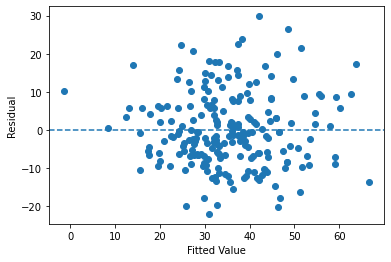

In [ ]:
#6. 잔차의 가정 확인
#1) 등분산성 확인
plt.scatter(reg_result.fittedvalues, reg_result.resid)
plt.xlabel("Fitted Value")
plt.ylabel("Residual")
plt.axhline(y=0, linestyle="--")

## y=0을 기준으로 잔차가 랜덤하게 산포되어 있기에 등분산성을 만족한다.

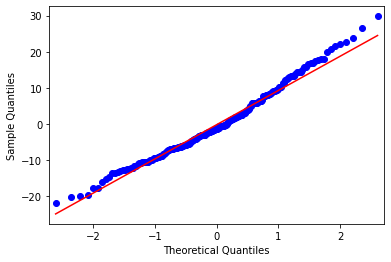

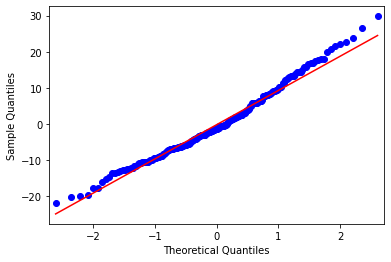

In [ ]:
#2) 정규성 검정
qqplot(reg_result.resid, line='q')

## 잔차가 정규분포 직선을 중심으로 분포하기에 정규성을 만족한다.

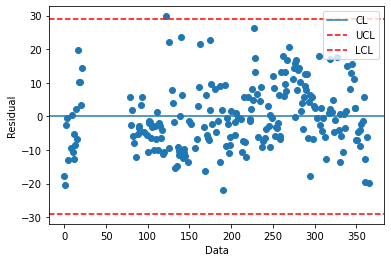

In [ ]:
#3) 독립성 검정
plt.scatter(df_train_dummy.index, reg_result.resid)
plt.xlabel("Data")
plt.ylabel("Residual")
plt.axhline(y=0, linestyle="-", label="CL")
plt.axhline(y=3*np.std(reg_result.resid), linestyle="--", color="red", label="UCL")
plt.axhline(y=-3*np.std(reg_result.resid), linestyle="dashed", color="red", label="LCL")
plt.legend()

### 한 점이 관리상하한 선에 걸쳐 있다고 본다. 이때, 잔차가 y=0을 기준으로 랜덤하게 산포되어 있으므로 독립성을 만족한다.

In [ ]:
#7. 회귀 모델의 성능 확인
train_pred = reg_result.predict(df_train_dummy)
test_pred = reg_result.predict(df_test_dummy)
print("train data의 결정계수: {0:.3f}".format(r2_score(df_train_dummy['PM10'], train_pred)))
print("test data의 결정계수: {0:.3f}".format(r2_score(df_test_dummy['PM10'], test_pred)))

train data의 결정계수: 0.555
test data의 결정계수: 0.453


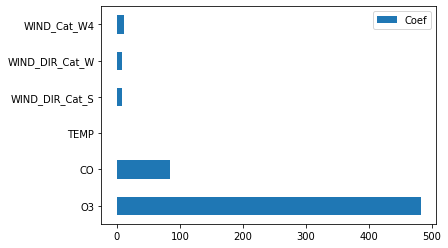

In [ ]:
#8. 결론 도출
df_reg_coef = pd.DataFrame({"Coef": reg_result.params.values[1:]},
                           index=['O3', 'CO', 'TEMP', 'WIND_DIR_Cat_S', \
                                  'WIND_DIR_Cat_W', 'WIND_Cat_W4'])
df_reg_coef.plot.barh(y='Coef')

## 결과적으로 O3와 CO가 목표변수 PM10에 영향을 가장 많이 주는 것을 볼 수 있었다. 하지만 비표준화 회귀계수 기준이기에 완벽히 신뢰할 수는 없다.

#2. 다중선형 회귀분석_Regularization

In [31]:
#1. 데이터 구성 - 더미 변수 확인
df_raw_dummy

,PM10,O3,NO2,CO,SO2,TEMP,HUMIDITY,ATM_PRESS,CLOUD,WIND_Cat_W1,WIND_Cat_W2,WIND_Cat_W3,WIND_Cat_W4,WIND_Cat_W5,WIND_DIR_Cat_E,WIND_DIR_Cat_N,WIND_DIR_Cat_S,WIND_DIR_Cat_W
0,29.0,0.054,0.021,0.5,0.003,24.03,63.2,995.1,5.70,0,1,0,0,0,0,0,0,1
1,26.0,0.053,0.020,0.5,0.003,24.29,63.2,998.6,3.83,0,1,0,0,0,0,0,0,1
2,30.0,0.042,0.023,0.4,0.003,24.18,65.3,998.3,6.29,0,1,0,0,0,0,0,0,1
3,28.0,0.034,0.026,0.4,0.003,25.35,58.6,996.6,2.54,0,1,0,0,0,0,0,0,1
4,29.0,0.045,0.035,0.5,0.003,27.30,45.5,993.5,3.92,1,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
361,19.0,0.039,0.016,0.4,0.003,21.66,84.0,996.0,8.73,0,0,1,0,0,0,0,0,1
362,22.0,0.044,0.017,0.4,0.004,23.94,69.8,995.8,6.21,0,1,0,0,0,0,0,1,0
363,27.0,0.044,0.009,0.4,0.003,25.03,71.3,994.7,2.63,0,1,0,0,0,0,0,0,1
364,36.0,0.026,0.028,0.6,0.003,24.06,75.5,992.9,7.58,0,1,0,0,0,1,0,0,0


In [32]:
#2. 목표변수와 설명변수 데이터 저장
df_raw_dummy_y = df_raw_dummy["PM10"]
df_raw_dummy_x = df_raw_dummy.drop("PM10", axis=1, inplace=False)

In [33]:
#3. train/test data 분리
df_raw_dummy_train_x, df_raw_dummy_test_x, df_raw_dummy_train_y, df_raw_dummy_test_y = train_test_split(df_raw_dummy_x, df_raw_dummy_y, test_size=0.3, random_state=1234)
print("train data X size: {}".format(df_raw_dummy_train_x.shape))
print("train data Y size: {}".format(df_raw_dummy_train_y.shape))
print("test data X size: {}".format(df_raw_dummy_test_x.shape))
print("test data Y size: {}".format(df_raw_dummy_test_y.shape))

train data X size: (217, 17)
train data Y size: (217,)
test data X size: (94, 17)
test data Y size: (94,)


# 2-1. Ridge 모델

In [ ]:
#1. 모델 생성
ridge = Ridge(random_state=1234, alpha=0.05)
ridge.fit(df_raw_dummy_train_x, df_raw_dummy_train_y)
print(ridge.intercept_) #절편값 확인

326.7878976648801


In [ ]:
#2. 회귀계수 확인
df_ridge_coef = pd.DataFrame({"Coef": ridge.coef_}, index=df_raw_dummy_train_x.columns)
df_ridge_coef

,Coef
O3,70.063030
NO2,-8.999270
CO,86.544283
SO2,0.042341
TEMP,0.027078
HUMIDITY,-0.155541
ATM_PRESS,-0.325319
CLOUD,-0.117148
WIND_Cat_W1,-5.938504
WIND_Cat_W2,-6.177595


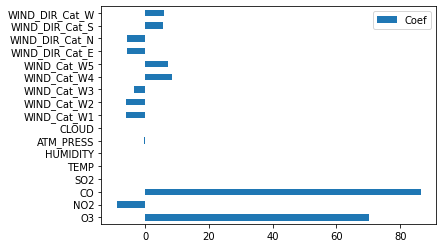

In [ ]:
#3. 회귀계수 그래프
df_ridge_coef.plot.barh(y='Coef')

In [ ]:
#4. 모델의 성능
train_pred = ridge.predict(df_raw_dummy_train_x)
test_pred = ridge.predict(df_raw_dummy_test_x)
print("train data의 결정계수: {0:.3f}".format(r2_score(df_raw_dummy_train_y, train_pred)))
print("test data의 결정계수: {0:.3f}".format(r2_score(df_raw_dummy_test_y, test_pred)))

train data의 결정계수: 0.542
test data의 결정계수: 0.452


#2-2. LASSO 모델

In [ ]:
#1. 모델 생성
lasso = Lasso(random_state=1234, alpha=0.01) 
lasso.fit(df_raw_dummy_train_x, df_raw_dummy_train_y)
print(lasso.intercept_) #절편값 확인

241.0005377987468


In [ ]:
#2. 회귀계수 확인
df_lasso_coef = pd.DataFrame({"Coef": lasso.coef_}, index=df_raw_dummy_train_x.columns)
df_lasso_coef 

,Coef
O3,217.092972
NO2,-0.000000
CO,87.801081
SO2,0.000000
TEMP,-0.047857
HUMIDITY,-0.142782
ATM_PRESS,-0.243243
CLOUD,-0.000000
WIND_Cat_W1,-2.026556
WIND_Cat_W2,-2.390521


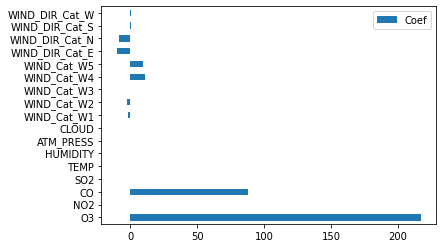

In [ ]:
#3. 회귀계수 그래프
df_lasso_coef.plot.barh(y='Coef')

In [ ]:
#4. 모델의 성능
train_pred = lasso.predict(df_raw_dummy_train_x)
test_pred = lasso.predict(df_raw_dummy_test_x)
print("train data의 결정계수: {0:.3f}".format(r2_score(df_raw_dummy_train_y, train_pred)))
print("test data의 결정계수: {0:.3f}".format(r2_score(df_raw_dummy_test_y, test_pred)))

train data의 결정계수: 0.560
test data의 결정계수: 0.460


# 3. ElasticNet 모델

In [ ]:
#1. 모델 생성
elastic = ElasticNet(random_state=1234, alpha=0.001, l1_ratio=0.5) 
elastic.fit(df_raw_dummy_train_x, df_raw_dummy_train_y)
print(elastic.intercept_) #절편값 확인

348.133537988943


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.984e+00, tolerance: 4.563e+00
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive


In [ ]:
#2. 회귀계수 확인
df_elastic_coef = pd.DataFrame({"Coef": elastic.coef_}, index=df_raw_dummy_train_x.columns)
df_elastic_coef 

,Coef
O3,34.502513
NO2,-2.637562
CO,83.864261
SO2,0.000000
TEMP,0.026182
HUMIDITY,-0.153960
ATM_PRESS,-0.344754
CLOUD,-0.145460
WIND_Cat_W1,-5.480624
WIND_Cat_W2,-5.860865


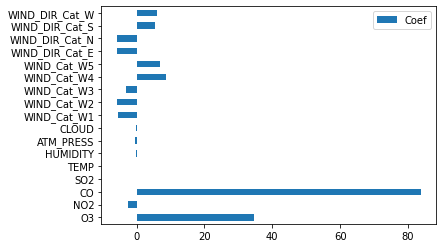

In [ ]:
#3. 회귀계수 그래프
df_elastic_coef.plot.barh(y='Coef')

In [ ]:
#4. 모델의 성능
train_pred = elastic.predict(df_raw_dummy_train_x)
test_pred = elastic.predict(df_raw_dummy_test_x)
print("train data의 결정계수: {0:.3f}".format(r2_score(df_raw_dummy_train_y, train_pred)))
print("test data의 결정계수: {0:.3f}".format(r2_score(df_raw_dummy_test_y, test_pred)))

train data의 결정계수: 0.535
test data의 결정계수: 0.448


## 3개의 규제화 회귀모델을 보면, 공통적으로 CO, O3, WIND_Cat_W4가 목표변수 PM10에 영향을 많이 주는 것을 볼 수 있다.

# 3. 의사결정트리(Decision Tree)_예측 

In [ ]:
#1. 범위 지정
para_depth = [depth for depth in range(1, 11)]
para_split = [n_split * 2 for n_split in range(1,21)]
para_leaf = [n_leaf * 1 for n_leaf in range(1,21)]

In [ ]:
#2. GridSearchCV를 이용한 최적의 파라미터 찾기
estimator = DecisionTreeRegressor(random_state=1234)

param_grid = {"criterion": ["mse","friedman_mse","mae"], "max_features": ["auto","sqrt","log2"],\
              "max_depth": para_depth, "min_samples_split": para_split, \
              "min_samples_leaf": para_leaf}

grid_dt = GridSearchCV(estimator, param_grid, scoring="r2", n_jobs=-1)
grid_dt.fit(df_raw_dummy_train_x, df_raw_dummy_train_y)

print("best estimator model: \n{}".format(grid_dt.best_estimator_))
print("\nbest parameter: \n{}".format(grid_dt.best_params_))
print("\nbest score: \n{}".format(grid_dt.best_score_.round(3)))

best estimator model: 
DecisionTreeRegressor(criterion='mse', max_depth=7, max_features='auto',
                      min_samples_leaf=6, min_samples_split=18,
                      random_state=1234)

best parameter: 
{'criterion': 'mse', 'max_depth': 7, 'max_features': 'auto', 'min_samples_leaf': 6, 'min_samples_split': 18}

best score: 
0.304


/usr/local/lib/python3.7/dist-packages/sklearn/tree/_classes.py:363: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,


In [ ]:
#3. 최종 모델 선정
tree_final = DecisionTreeRegressor(random_state=1234, min_samples_leaf=6, min_samples_split=18, max_depth=7)
tree_final.fit(df_raw_dummy_train_x, df_raw_dummy_train_y)

print("Score on training set: {:.3f}".format(tree_final.score(df_raw_dummy_train_x, df_raw_dummy_train_y)))
print("Score on test set: {:.3f}".format(tree_final.score(df_raw_dummy_test_x, df_raw_dummy_test_y)))

Score on training set: 0.664
Score on test set: 0.321


In [ ]:
#4. 결론 도출(1) - 설명변수의 중요도 결과

#변수명 저장
v_feature_name = df_raw_dummy_train_x.columns

df_importance= pd.DataFrame()
df_importance["Feature"] = v_feature_name
df_importance["Importance"] = tree_final.feature_importances_

#df_feature_importance의 테이블을 중요도별로 정렬
df_importance.sort_values("Importance", ascending=False, inplace=True)
df_importance.round(3)

,Feature,Importance
2,CO,0.527
0,O3,0.214
7,CLOUD,0.092
1,NO2,0.048
4,TEMP,0.047
5,HUMIDITY,0.039
11,WIND_Cat_W4,0.028
6,ATM_PRESS,0.005
12,WIND_Cat_W5,0.000
15,WIND_DIR_Cat_S,0.000


Text(0, 0.5, 'Feature')

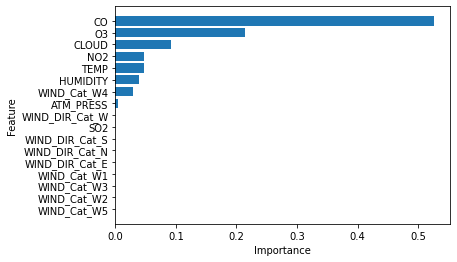

In [ ]:
#4. 결론 도출(2) - 설명변수 중요도 그래프
df_importance.sort_values("Importance", ascending=True, inplace=True)
coordinates = range(len(df_importance))
plt.barh(y=coordinates, width=df_importance['Importance'])
plt.yticks(coordinates, df_importance["Feature"])
plt.xlabel("Importance")
plt.ylabel("Feature")

# 4. 랜덤포레스트(Random Forest)_예측

In [ ]:
#1. 범위 지정
para_depth = [depth for depth in range(1, 11)]
para_split = [n_split * 2 for n_split in range(1,21)]
para_leaf = [n_leaf * 1 for n_leaf in range(1,21)]
para_n_tree = [n_tree * 10 for n_tree in range(1,11)]

In [ ]:
#2. GridSearchCV를 이용한 최적의 파라미터 찾기
estimator = RandomForestRegressor(random_state=1234)

param_grid = {"criterion": ["mse","friedman_mse","mae"], "max_features": ["auto","sqrt","log2"],\
              "max_depth": para_depth, "min_samples_split": para_split, \
              "min_samples_leaf": para_leaf, "n_estimators": para_n_tree}

grid_rf = GridSearchCV(estimator, param_grid, scoring="r2", n_jobs=-1)
grid_rf.fit(df_raw_dummy_train_x, df_raw_dummy_train_y)

print("best estimator model: \n{}".format(grid_rf.best_estimator_))
print("\nbest parameter: \n{}".format(grid_rf.best_params_))
print("\nbest score: \n{}".format(grid_rf.best_score_.round(3)))

KeyboardInterrupt: ignored

## **3시간이 넘게 돌렸음에도 GridSearchCV 결과가 바로 도출되지 않아 직접 해보기로 한다.**

In [37]:
#1.기본 옵션으로 모델 생성
rf_uncustomized= RandomForestRegressor(random_state=1234)

In [39]:
rf_uncustomized.fit(df_raw_dummy_train_x, df_raw_dummy_train_y)
print("Score training set: {:.3f}".format(rf_uncustomized.score(df_raw_dummy_train_x, df_raw_dummy_train_y)))
print("Score test set: {:.3f}".format(rf_uncustomized.score(df_raw_dummy_test_x, df_raw_dummy_test_y)))

Score training set: 0.916
Score test set: 0.428


In [40]:
#2. Parameter 조정 - n_estimators(1)
train_score = []
test_score = []

para_n_tree = [n_tree * 10 for n_tree in range(1,11)]

for v_n_estimators in para_n_tree:
    rf = RandomForestRegressor(random_state=1234, n_estimators=v_n_estimators)
    rf.fit(df_raw_dummy_train_x, df_raw_dummy_train_y)
    train_score.append(rf.score(df_raw_dummy_train_x, df_raw_dummy_train_y))
    test_score.append(rf.score(df_raw_dummy_test_x, df_raw_dummy_test_y))
    
#결과 저장
df_score_n = pd.DataFrame()
df_score_n['n_estimators'] = para_n_tree
df_score_n['TrainScore'] = train_score
df_score_n['TestScore'] = test_score

#모델 설명력 확인
df_score_n.round(3)

,n_estimators,TrainScore,TestScore
0,10,0.892,0.386
1,20,0.905,0.401
2,30,0.915,0.416
3,40,0.913,0.422
4,50,0.911,0.423
5,60,0.915,0.432
6,70,0.915,0.430
7,80,0.915,0.429
8,90,0.915,0.426
9,100,0.916,0.428


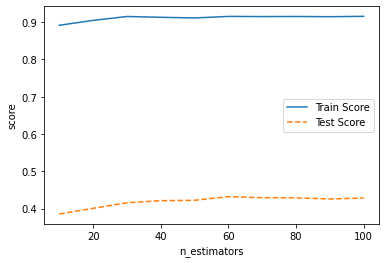

In [41]:
#모델 설명력 그래프 확인
plt.plot(para_n_tree, train_score, linestyle="-", label="Train Score")
plt.plot(para_n_tree, test_score, linestyle="--", label="Test Score")
plt.ylabel("score")
plt.xlabel("n_estimators")
plt.legend()

## train_score와 test_score의 값을 서로 고려하며 트리 수를 60개로 지정한다.

In [42]:
#2. Parameter 조정 - min_samples_leaf(2)
train_score = []
test_score = []

para_leaf = [n_leaf * 1 for n_leaf in range(1, 21)]

for v_min_samples_leaf in para_leaf:
    rf = RandomForestRegressor(random_state=1234, n_estimators=60, min_samples_leaf=v_min_samples_leaf)
    rf.fit(df_raw_dummy_train_x, df_raw_dummy_train_y)
    train_score.append(rf.score(df_raw_dummy_train_x, df_raw_dummy_train_y))
    test_score.append(rf.score(df_raw_dummy_test_x, df_raw_dummy_test_y))
    
#결과 저장
df_score_leaf = pd.DataFrame()
df_score_leaf['MinSamplesLeaf'] = para_leaf
df_score_leaf['TrainScore'] = train_score
df_score_leaf['TestScore'] = test_score

#모델 설명력 확인
df_score_leaf.round(3)

,MinSamplesLeaf,TrainScore,TestScore
0,1,0.915,0.432
1,2,0.878,0.432
2,3,0.826,0.425
3,4,0.781,0.414
4,5,0.746,0.416
5,6,0.713,0.412
6,7,0.683,0.407
7,8,0.658,0.399
8,9,0.632,0.400
9,10,0.612,0.391


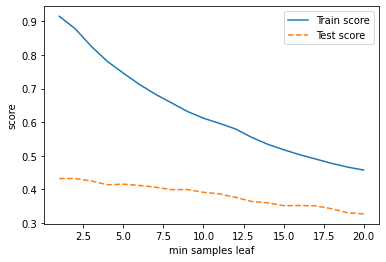

In [43]:
plt.plot(para_leaf, train_score, linestyle='-', label='Train score')
plt.plot(para_leaf, test_score, linestyle='--', label='Test score')
plt.ylabel("score")
plt.xlabel("min samples leaf")
plt.legend()

## train_score와 test_score의 값을 서로 고려하며 leaf node의 최소 자료 수를 3개로 지정한다.

In [44]:
#2. Parameter 조정 - min_samples_split(3)
train_score = []
test_score = []

para_split = [n_split * 2 for n_split in range(2, 21)]

for v_min_samples_split in para_split:
    rf = RandomForestRegressor(random_state=1234, n_estimators=60, min_samples_leaf=3, \
                              min_samples_split=v_min_samples_split)
    rf.fit(df_raw_dummy_train_x, df_raw_dummy_train_y)
    train_score.append(rf.score(df_raw_dummy_train_x, df_raw_dummy_train_y))
    test_score.append(rf.score(df_raw_dummy_test_x, df_raw_dummy_test_y))
    
#결과 저장
df_score_split = pd.DataFrame()
df_score_split['MinSamplesSplit'] = para_split
df_score_split['TrainScore'] = train_score
df_score_split['TestScore'] = test_score

#모델 설명력 확인
df_score_split.round(3)

,MinSamplesSplit,TrainScore,TestScore
0,4,0.826,0.425
1,6,0.826,0.425
2,8,0.798,0.428
3,10,0.768,0.424
4,12,0.746,0.420
5,14,0.722,0.418
6,16,0.696,0.418
7,18,0.678,0.410
8,20,0.663,0.407
9,22,0.648,0.405


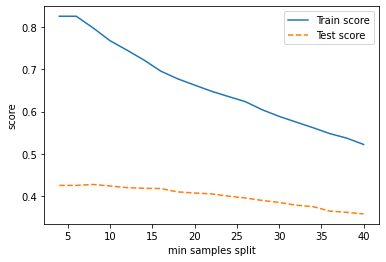

In [45]:
plt.plot(para_split, train_score, linestyle='-', label='Train score')
plt.plot(para_split, test_score, linestyle='--', label='Test score')
plt.ylabel("score")
plt.xlabel("min samples split")
plt.legend()

## train_score와 test_score의 값을 서로 고려하며 분리 노드의 최소 자료 수를 10개로 지정한다.

In [46]:
#2. Parameter 조정 - max_depth(4)
train_score = []
test_score = []
    
para_depth = [depth for depth in range(1,20)]

for v_max_depth in para_depth:
    rf = RandomForestRegressor(random_state=1234, n_estimators=60, 
            min_samples_leaf=3, min_samples_split=10, max_depth=v_max_depth)
    rf.fit(df_raw_dummy_train_x, df_raw_dummy_train_y)
    train_score.append(rf.score(df_raw_dummy_train_x, df_raw_dummy_train_y))
    test_score.append(rf.score(df_raw_dummy_test_x, df_raw_dummy_test_y))
    
#데이터 테이블로 저장
df_score_depth = pd.DataFrame()
df_score_depth['Depth'] = para_depth
df_score_depth['TrainScore'] = train_score
df_score_depth['TestScore'] = test_score

#모델 설명력 확인
df_score_depth.round(3)


,Depth,TrainScore,TestScore
0,1,0.277,0.243
1,2,0.423,0.329
2,3,0.559,0.381
3,4,0.652,0.410
4,5,0.711,0.414
5,6,0.743,0.425
6,7,0.758,0.421
7,8,0.765,0.423
8,9,0.767,0.424
9,10,0.768,0.424


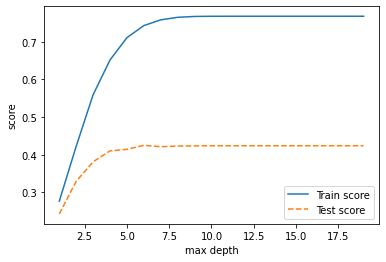

In [47]:
plt.plot(para_depth, train_score, linestyle='-', label='Train score')
plt.plot(para_depth, test_score, linestyle='--', label='Test score')
plt.ylabel("score")
plt.xlabel("max depth")
plt.legend()

## train_score와 test_score의 값을 서로 고려하며 max_depth를 6으로 지정한다.

In [48]:
#3. 최종 모델 선정
rf_final = RandomForestRegressor(random_state=1234, min_samples_leaf=3, min_samples_split=10, max_depth=6, \
                                   n_estimators=60)
rf_final.fit(df_raw_dummy_train_x, df_raw_dummy_train_y)

print("Score on training set: {:.3f}".format(rf_final.score(df_raw_dummy_train_x, df_raw_dummy_train_y)))
print("Score on test set: {:.3f}".format(rf_final.score(df_raw_dummy_test_x, df_raw_dummy_test_y)))


Score on training set: 0.743
Score on test set: 0.425


## 기본 옵션보다는 train data에 덜 과대적합하나 여전히 과대적합하는 모습을 보이고 있다.

In [49]:
#4. 결론 도출(1) - 설명변수의 중요도 결과

#변수명 저장
v_feature_name = df_raw_dummy_train_x.columns

rf_importance= pd.DataFrame()
rf_importance["Feature"] = v_feature_name
rf_importance["Importance"] = rf_final.feature_importances_

#df_feature_importance의 테이블을 중요도별로 정렬
rf_importance.sort_values("Importance", ascending=False, inplace=True)
rf_importance.round(3)

,Feature,Importance
2,CO,0.447
0,O3,0.141
7,CLOUD,0.086
5,HUMIDITY,0.084
4,TEMP,0.070
6,ATM_PRESS,0.039
1,NO2,0.038
11,WIND_Cat_W4,0.029
13,WIND_DIR_Cat_E,0.020
3,SO2,0.017


Text(0, 0.5, 'Feature')

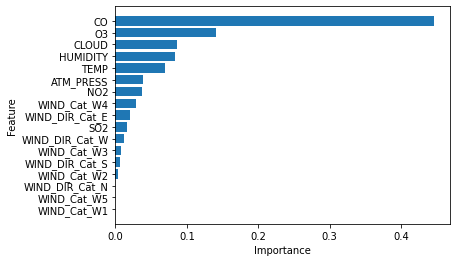

In [50]:
#4. 결론 도출(2) - 설명변수 중요도 그래프
rf_importance.sort_values("Importance", ascending=True, inplace=True)
coordinates = range(len(rf_importance))
plt.barh(y=coordinates, width=rf_importance['Importance'])
plt.yticks(coordinates, rf_importance["Feature"])
plt.xlabel("Importance")
plt.ylabel("Feature")

# 5. 그래디언트 부스팅(Gradient Boosting)_예측

In [ ]:
#1. 범위 지정
para_depth = [depth for depth in range(1, 11)]
para_split = [n_split * 2 for n_split in range(1,21)]
para_leaf = [n_leaf * 1 for n_leaf in range(1,21)]
para_n_tree = [n_tree * 10 for n_tree in range(1,11)]
para_lr = [lr * 0.1 for lr in range(1,11)]

In [ ]:
#2. GridSearchCV를 이용한 최적의 파라미터 찾기
estimator = GradientBoostingRegressor(random_state=1234)

param_grid = {"criterion": ["mse","fiedman_mse","mae"], "max_features": ["auto","sqrt","log2"],\
              "max_depth": para_depth, "min_samples_split": para_split, \
              "min_samples_leaf": para_leaf, "n_estimators": para_n_tree, "learning_rate": para_lr}

grid_gb = GridSearchCV(estimator, param_grid, scoring="r2", n_jobs=-1)
grid_gb.fit(df_raw_dummy_train_x, df_raw_dummy_train_y)

print("best estimator model: \n{}".format(grid_gb.best_estimator_))
print("\nbest parameter: \n{}".format(grid_gb.best_params_))
print("\nbest score: \n{}".format(grid_gb.best_score_.round(3)))

## **Gradient Boosting도 GridSearchCV를 통해 최적의 파라미터를 찾으려 했으나 코드만 적어놓고 직접 파라미터를 조정하는 과정을 거친다.**

In [52]:
#1.기본 옵션으로 모델 생성
gb_uncustomized = GradientBoostingRegressor(random_state=1234)
gb_uncustomized.fit(df_raw_dummy_train_x, df_raw_dummy_train_y)

print('Score on training set: {:.3f}'.format(gb_uncustomized.score(df_raw_dummy_train_x, df_raw_dummy_train_y)))
print('Score on test set: {:.3f}'.format(gb_uncustomized.score(df_raw_dummy_test_x, df_raw_dummy_test_y)))

Score on training set: 0.920
Score on test set: 0.491


In [53]:
#2. Parameter 조정 - n_estimators(1)

#train, test 설명력 결과 저장
train_score = []
test_score = []

#1. n_estimators: 트리 수 변경 1~100
para_n_tree = [n_tree * 10 for n_tree in range(1,11)]

for v_n_estimators in para_n_tree:
    gb = GradientBoostingRegressor(random_state=1234, n_estimators=v_n_estimators)
    gb.fit(df_raw_dummy_train_x, df_raw_dummy_train_y)
    train_score.append(gb.score(df_raw_dummy_train_x, df_raw_dummy_train_y))
    test_score.append(gb.score(df_raw_dummy_test_x, df_raw_dummy_test_y))
    
#결과 저장
df_score_n = pd.DataFrame()
df_score_n['Estimators'] = para_n_tree
df_score_n['TrainScore'] = train_score
df_score_n['TestScore'] = test_score

#모델 설명력 확인
df_score_n.round(3)

,Estimators,TrainScore,TestScore
0,10,0.494,0.332
1,20,0.680,0.442
2,30,0.765,0.461
3,40,0.806,0.477
4,50,0.835,0.483
5,60,0.862,0.483
6,70,0.876,0.484
7,80,0.897,0.488
8,90,0.910,0.491
9,100,0.920,0.491


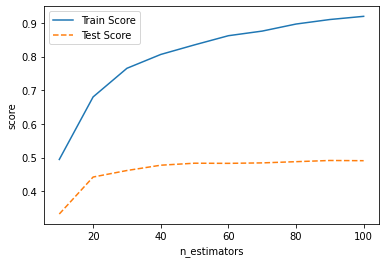

In [54]:
#모델 설명력 그래프 확인
plt.plot(para_n_tree, train_score, linestyle="-", label="Train Score")
plt.plot(para_n_tree, test_score, linestyle="--", label="Test Score")
plt.ylabel("score")
plt.xlabel("n_estimators")
plt.legend()

## train_score와 test_score의 값을 서로 고려하며 트리의 수를 80개로 지정한다.

In [59]:
#2. Parameter 조정 - min_samples_leaf(2)

train_score = []
test_score = []

para_leaf = [n_leaf * 1 for n_leaf in range(1, 21)]

for v_min_samples_leaf in para_leaf:
    gb = GradientBoostingRegressor(random_state=1234, n_estimators=80, min_samples_leaf=v_min_samples_leaf)
    gb.fit(df_raw_dummy_train_x, df_raw_dummy_train_y)
    train_score.append(gb.score(df_raw_dummy_train_x, df_raw_dummy_train_y))
    test_score.append(gb.score(df_raw_dummy_test_x, df_raw_dummy_test_y))
    
#결과 저장
df_score_leaf = pd.DataFrame()
df_score_leaf['MinSamplesLeaf'] = para_leaf
df_score_leaf['TrainScore'] = train_score
df_score_leaf['TestScore'] = test_score

#모델 설명력 확인
df_score_leaf.round(3)

,MinSamplesLeaf,TrainScore,TestScore
0,1,0.897,0.488
1,2,0.888,0.502
2,3,0.884,0.472
3,4,0.879,0.481
4,5,0.873,0.485
5,6,0.869,0.451
6,7,0.867,0.449
7,8,0.862,0.454
8,9,0.854,0.461
9,10,0.855,0.451


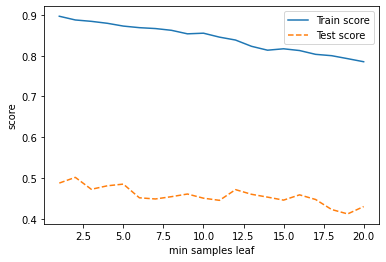

In [60]:
plt.plot(para_leaf, train_score, linestyle='-', label='Train score')
plt.plot(para_leaf, test_score, linestyle='--', label='Test score')
plt.ylabel("score")
plt.xlabel("min samples leaf")
plt.legend()

## train_score와 test_score의 값을 서로 고려하며 leaf node의 최소 자료 수를 12로 지정한다.

In [61]:
#2. Parameter 조정 - min_samples_split(3)

train_score = []
test_score = []

para_split = [n_split * 2 for n_split in range(1, 21)]


for v_min_samples_split in para_split:
    gb = GradientBoostingRegressor(random_state=1234, n_estimators=80, min_samples_leaf=12, \
                                  min_samples_split=v_min_samples_split)
    gb.fit(df_raw_dummy_train_x, df_raw_dummy_train_y)
    train_score.append(gb.score(df_raw_dummy_train_x, df_raw_dummy_train_y))
    test_score.append(gb.score(df_raw_dummy_test_x, df_raw_dummy_test_y))
    
#결과 저장
df_score_split = pd.DataFrame()
df_score_split['MinSamplesSplit'] = para_split
df_score_split['TrainScore'] = train_score
df_score_split['TestScore'] = test_score

#모델 설명력 확인
df_score_split.round(3)

,MinSamplesSplit,TrainScore,TestScore
0,2,0.838,0.472
1,4,0.838,0.472
2,6,0.838,0.472
3,8,0.838,0.472
4,10,0.838,0.472
5,12,0.838,0.472
6,14,0.838,0.472
7,16,0.838,0.472
8,18,0.838,0.472
9,20,0.838,0.472


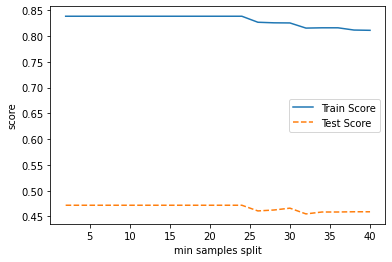

In [62]:
#모델 설명력 그래프 확인
plt.plot(para_split, train_score, linestyle="-", label="Train Score")
plt.plot(para_split, test_score, linestyle="--", label="Test Score")
plt.ylabel("score")
plt.xlabel("min samples split")
plt.legend()

## train_score와 test_score의 값을 서로 고려하며 분리 노드의 최소 자료 수를 24로 지정한다.

In [63]:
#2. Parameter 조정 - max_depth(4)

#train 및 test 설명력 결과 저장
train_score = []
test_score = []
    
para_depth = [depth for depth in range(1,11)]

for v_max_depth in para_depth:
    gb = GradientBoostingRegressor(random_state=1234, n_estimators=80, min_samples_leaf=12, \
                                  min_samples_split=24, max_depth=v_max_depth)
    gb.fit(df_raw_dummy_train_x, df_raw_dummy_train_y)
    train_score.append(gb.score(df_raw_dummy_train_x, df_raw_dummy_train_y))
    test_score.append(gb.score(df_raw_dummy_test_x, df_raw_dummy_test_y))
    
#결과 저장
df_score_depth = pd.DataFrame()
df_score_depth['Depth'] = para_depth
df_score_depth['TrainScore'] = train_score
df_score_depth['TestScore'] = test_score

#모델 설명력 확인
df_score_depth.round(3)

,Depth,TrainScore,TestScore
0,1,0.515,0.350
1,2,0.731,0.468
2,3,0.838,0.472
3,4,0.878,0.474
4,5,0.920,0.447
5,6,0.929,0.462
6,7,0.942,0.446
7,8,0.951,0.449
8,9,0.953,0.458
9,10,0.953,0.463


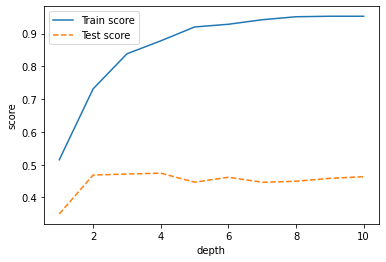

In [64]:
plt.plot(para_depth, train_score, linestyle='-', label='Train score')
plt.plot(para_depth, test_score, linestyle='--', label='Test score')
plt.ylabel("score")
plt.xlabel("depth")
plt.legend()

## train_score와 test_score의 값을 서로 고려하며 최대 깊이를 6으로 지정한다.

In [65]:
#2. Parameter 조정 - learning_rate(5)

#train 및 test 설명력 결과 저장
train_score = []
test_score = []
    
para_lr = [lr * 0.1 for lr in range(1,10)]

for v_learning_rate in para_lr:
    gb = GradientBoostingRegressor(random_state=1234, n_estimators=80, min_samples_leaf=12, \
                                  min_samples_split=24, max_depth=6, learning_rate=v_learning_rate)
    gb.fit(df_raw_dummy_train_x, df_raw_dummy_train_y)
    train_score.append(gb.score(df_raw_dummy_train_x, df_raw_dummy_train_y))
    test_score.append(gb.score(df_raw_dummy_test_x, df_raw_dummy_test_y))
    
#결과 저장
df_score_lr = pd.DataFrame()
df_score_lr['LearningRate'] = para_lr
df_score_lr['TrainScore'] = train_score
df_score_lr['TestScore'] = test_score

#모델 설명력 확인
df_score_lr.round(3)

,LearningRate,TrainScore,TestScore
0,0.1,0.929,0.462
1,0.2,0.980,0.492
2,0.3,0.992,0.470
3,0.4,0.998,0.466
4,0.5,0.999,0.415
5,0.6,1.000,0.452
6,0.7,1.000,0.422
7,0.8,1.000,0.387
8,0.9,1.000,0.360


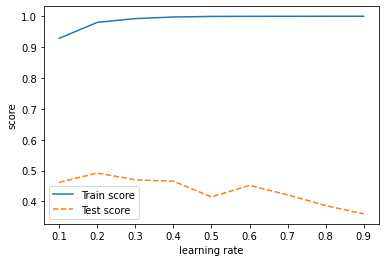

In [66]:
plt.plot(para_lr, train_score, linestyle='-', label='Train score')
plt.plot(para_lr, test_score, linestyle='--', label='Test score')
plt.ylabel("score")
plt.xlabel("learning rate")
plt.legend()

## train_score와 test_score의 값을 서로 고려하며 학습률을 0.2로 지정한다.

In [67]:
#3. 최종 모델 선정
gb_final = GradientBoostingRegressor(random_state=1234, min_samples_leaf=12, min_samples_split=24, max_depth=6, \
                                       n_estimators=80, learning_rate=0.2)
gb_final.fit(df_raw_dummy_train_x, df_raw_dummy_train_y)

print("Score on training set: {:.3f}".format(gb_final.score(df_raw_dummy_train_x, df_raw_dummy_train_y)))
print("Score on test set: {:.3f}".format(gb_final.score(df_raw_dummy_test_x, df_raw_dummy_test_y)))


Score on training set: 0.980
Score on test set: 0.492


## train data에 과대적합하고 있는 모습을 보여 아쉬운 성능을 보인다.

In [68]:
#4. 결론 도출(1) - 설명변수의 중요도 결과

#변수명 저장
v_feature_name = df_raw_dummy_train_x.columns

gb_importance= pd.DataFrame()
gb_importance["Feature"] = v_feature_name
gb_importance["Importance"] = gb_final.feature_importances_

#df_feature_importance의 테이블을 중요도별로 정렬
gb_importance.sort_values("Importance", ascending=False, inplace=True)
gb_importance.round(3)

,Feature,Importance
2,CO,0.383
0,O3,0.173
7,CLOUD,0.110
4,TEMP,0.101
5,HUMIDITY,0.078
6,ATM_PRESS,0.065
1,NO2,0.042
16,WIND_DIR_Cat_W,0.016
11,WIND_Cat_W4,0.012
13,WIND_DIR_Cat_E,0.010


Text(0, 0.5, 'Feature')

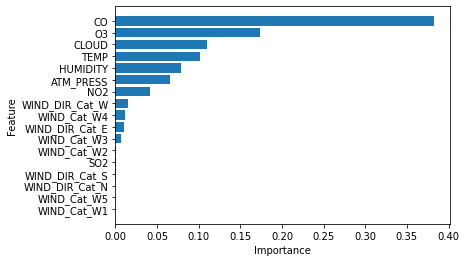

In [69]:
#4. 결론 도출(2) - 설명변수 중요도 그래프
gb_importance.sort_values("Importance", ascending=True, inplace=True)
coordinates = range(len(gb_importance))
plt.barh(y=coordinates, width=gb_importance['Importance'])
plt.yticks(coordinates, gb_importance["Feature"])
plt.xlabel("Importance")
plt.ylabel("Feature")

## 3개의 트리 모델을 보면, 공통적으로 CO, O3, CLOUD가 목표변수 PM10에 영향을 많이 주는 것을 볼 수 있다.